ADS 505 Final Project

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [85]:
Bank_df = pd.read_csv("Data/BankChurners.csv")
Bank_df = Bank_df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)

In [86]:
Bank_df.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [87]:
missing_values_count = Bank_df.isnull().sum()
print(missing_values_count)

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [88]:
Bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

(array([1402.,    0., 3561.,    0., 1535.,    0., 1790.,    0.,  727.,
        1112.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

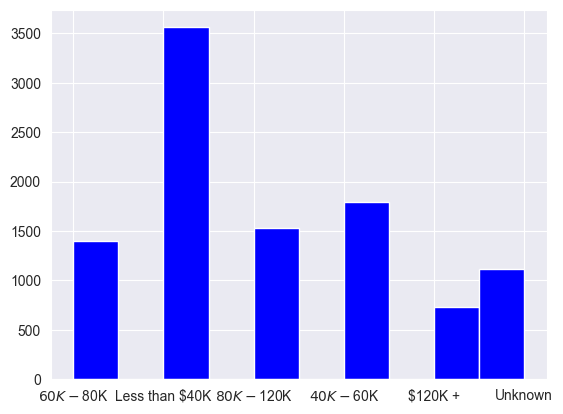

In [89]:
plt.hist(Bank_df["Income_Category"], bins = 10, color = 'blue')

In [90]:
# Select only numerical columns
numerical_columns = Bank_df.select_dtypes(include=['number'])

# Display the resulting DataFrame with numerical columns
print(numerical_columns)

       CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
0      768805383            45                3              39   
1      818770008            49                5              44   
2      713982108            51                3              36   
3      769911858            40                4              34   
4      709106358            40                3              21   
...          ...           ...              ...             ...   
10122  772366833            50                2              40   
10123  710638233            41                2              25   
10124  716506083            44                1              36   
10125  717406983            30                2              36   
10126  714337233            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                 

In [91]:
correlation_matrix = numerical_columns.corr()

<Axes: >

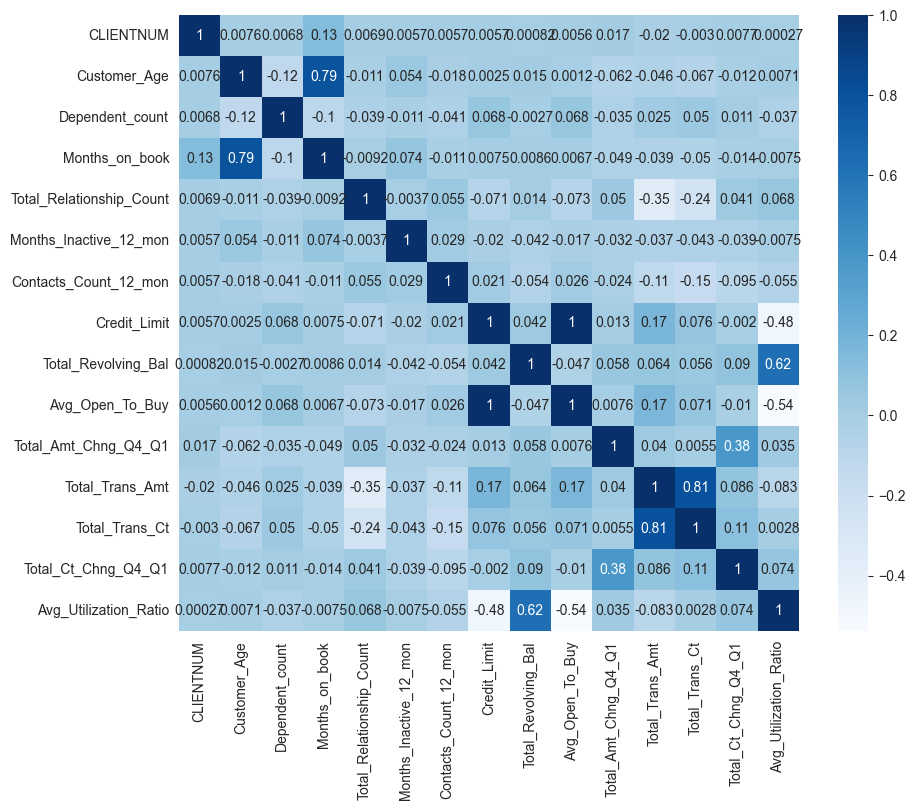

In [92]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues')

(array([110.,  29.,  56.,  70.,  91., 106., 127., 146., 184., 221., 260.,
        303., 333., 361., 379., 426., 473., 500., 486., 490., 479., 472.,
        947., 398., 376., 387., 307., 279., 262., 223., 157., 157., 127.,
         93.,  93.,  65.,  43., 101.,   2.,   4.,   2.,   0.,   1.,   0.,
          1.]),
 array([26.        , 27.04444444, 28.08888889, 29.13333333, 30.17777778,
        31.22222222, 32.26666667, 33.31111111, 34.35555556, 35.4       ,
        36.44444444, 37.48888889, 38.53333333, 39.57777778, 40.62222222,
        41.66666667, 42.71111111, 43.75555556, 44.8       , 45.84444444,
        46.88888889, 47.93333333, 48.97777778, 50.02222222, 51.06666667,
        52.11111111, 53.15555556, 54.2       , 55.24444444, 56.28888889,
        57.33333333, 58.37777778, 59.42222222, 60.46666667, 61.51111111,
        62.55555556, 63.6       , 64.64444444, 65.68888889, 66.73333333,
        67.77777778, 68.82222222, 69.86666667, 70.91111111, 71.95555556,
        73.        ]),
 <BarCon

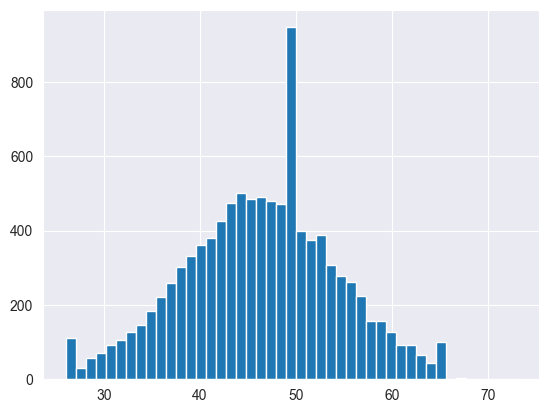

In [98]:
plt.hist(Bank_df['Customer_Age'], bins = 45)

C:\Users\Jeremiah\AppData\Local\Temp\ipykernel_16488\4285311919.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Bank_df['Customer_Age'])
C:\Users\Jeremiah\anaconda3\envs\ADS505_Module1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jeremiah\anaconda3\envs\ADS505_Module1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating in

<Axes: xlabel='Customer_Age', ylabel='Density'>

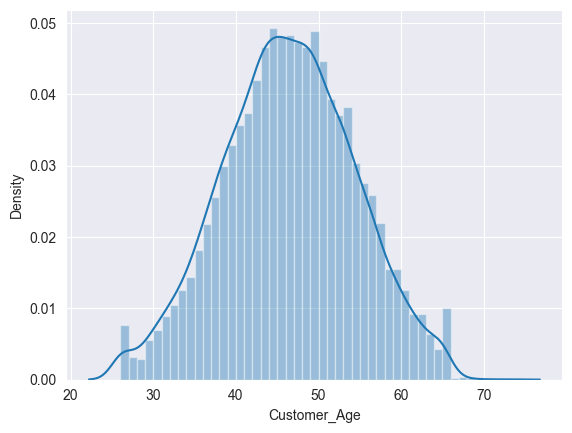

In [101]:
sns.distplot(Bank_df['Customer_Age'])

C:\Users\Jeremiah\anaconda3\envs\ADS505_Module1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jeremiah\anaconda3\envs\ADS505_Module1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jeremiah\anaconda3\envs\ADS505_Module1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Jeremiah\anaconda3\envs\ADS505_Module1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

<Axes: xlabel='Education_Level', ylabel='count'>

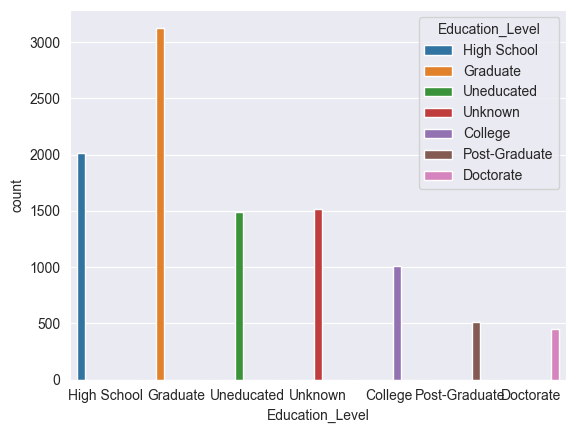

In [108]:
sns.countplot(data = Bank_df, x = 'Education_Level', hue = 'Education_Level')